# Présentation du Notebook

Ce notebook vise à effectuer des analyses linguistiques sur un ensemble de données multilingue, en utilisant des techniques de traitement du langage naturel (NLP). Il fournit des outils pour tokeniser des textes dans différentes langues, calculer des statistiques descriptives, évaluer la diversité lexicale, visualiser la loi de Zipf pour chaque langue traitée et évaluer la corrélation entre la longueur des textes et la diversité lexicale. Le tokenizer de la bibliothèque Transformers, spécifiquement XLM-RoBERTa, est utilisé pour la tokenisation et l'analyse linguistique.

## Fonctions principales :
- `tokenize(text: str, max_length: int = 512) -> list`:
  - **Objectif** : Tokenise le texte en utilisant le tokenizer XLM-RoBERTa, en respectant une longueur maximale spécifiée pour gérer efficacement la taille des données.
  - **Utilisation** : Cette fonction divise le texte en segments qui s'adaptent à la longueur maximale, assurant ainsi que chaque segment peut être traité sans perte d'information due à la coupure de mots.

- `get_stats(dataset: pd.DataFrame) -> pd.DataFrame`:
  - **Objectif** : Fournit des statistiques descriptives pour le corpus de données, telles que le nombre de textes et la moyenne de tokens par texte.
  - **Utilisation** : Utile pour obtenir un aperçu quantitatif du corpus, ce qui aide à comprendre la distribution générale des données, y compris la fréquence et la répartition des textes par langue.

- `calculate_metrics(dataset: pd.DataFrame) -> dict`:
  - **Objectif** : Évalue la diversité lexicale et d'autres métriques linguistiques pour chaque langue du dataset.
  - **Utilisation** : Ces métriques aident à comprendre la complexité linguistique des textes analysés, offrant des insights sur la richesse du vocabulaire et l'unicité des mots utilisés.

- `calculate_correlation(df: pd.DataFrame) -> dict`:
  - **Objectif** : Calcule la corrélation entre la longueur des textes et la diversité lexicale pour chaque langue.
  - **Utilisation** : Utilise le coefficient de corrélation de Pearson pour déterminer si la longueur des textes et la diversité lexicale sont corrélées.

- `loi_zipf_par_lang(data: pd.DataFrame) -> pd.DataFrame`:
  - **Objectif** : Analyse et visualise la distribution de la fréquence des mots suivant la loi de Zipf pour chaque langue.
  - **Utilisation** : Cette fonction illustre comment certains mots sont fréquemment utilisés par rapport à d'autres, fournissant une base pour l'analyse statistique du langage.

- `plot_zipf(data: pd.DataFrame) -> plt.Figure`:
  - **Objectif** : Crée des graphiques visualisant la loi de Zipf pour chaque langue analysée.
  - **Utilisation** : Permet une comparaison visuelle entre les langues, illustrant les différences dans l'utilisation des mots et la diversité linguistique.

- `count_entities(dataset: list) -> dict`:
  - **Objectif** : Compte le nombre d'entités de chaque type par langue dans un dataset.
  - **Utilisation** : Fournit une analyse des entités nommées et autres catégories grammaticales, enrichissant l'analyse linguistique avec des données sur la structure des phrases.

- `save_entities_to_csv(entities: dict, file_path: str) -> None`:
  - **Objectif** : Sauvegarde les entités comptées dans un fichier CSV.
  - **Utilisation** : Permet de stocker et d'accéder facilement aux données extraites pour des analyses ultérieures ou des rapports.


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import jupyter_black
from datasets import load_dataset
from collections import defaultdict
from transformers import AutoTokenizer
from scipy.stats import pearsonr

In [2]:
jupyter_black.load()

## Chargement des données

In [3]:
data = load_dataset("csv", data_files="../../data/csv/data.csv")["train"]

## Tokenization

In [4]:
label_names = data.unique("Label")
label_mapping = {label: idx for idx, label in enumerate(label_names)}

In [5]:
model_ckpt = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)


def tokenize(text: str, max_length: int = 512) -> list:
    """
    Tokenise un texte en utilisant le tokenizer d'xlm-roberta-base

    Parameters:
    text (str): le texte à tokeniser

    Returns:
    list: une liste de tokens
    """
    # Initialize an empty list to store tokens
    tokens = []
    # Split the text into parts that fit within the maximum sequence length
    for i in range(0, len(text), max_length - 2):  # Adjust for special tokens
        part = text[i : i + max_length - 2]
        tokenized_output = tokenizer(part, add_special_tokens=True, truncation=True)
        part_tokens = tokenizer.convert_ids_to_tokens(tokenized_output["input_ids"])
        tokens.extend(part_tokens)
    return tokens

## Statistiques descriptives des données

Statistiques descriptives utilisé également pour l'analyse du corpus de référence. [Lien vers l'article](https://medium.com/besedo-engineering/language-identification-for-very-short-texts-a-review-c9f2756773ad)

In [6]:
def get_stats(dataset):
    """
    Permet de calculer des statistiques sur les données

    Parameters:
    data (pd.DataFrame): les données

    Returns:
    pd.DataFrame: les statistiques calculées
        n_text: le nombre de textes
        n_text_per_lang: le nombre de textes par langue
        mean_tokens_per_text: le nombre moyen de tokens par texte
        n_text_under_100_chars: le nombre de textes de moins de 100 caractères par langue
        ratio_text_under_100_tokens: le ratio de textes de moins de 100 tokens par langue
    """
    languages = defaultdict(int)
    tokens = defaultdict(list)
    n_text_under_100_chars = defaultdict(int)
    texts_under_100_tokens = defaultdict(int)

    # Calcul de statistiques de base et de tokenisation
    for example in dataset:
        lang = example["Label"]
        text = example["Text"]
        token_list = tokenize(text)
        languages[lang] += 1
        tokens[lang].extend(token_list)
        if len(text) < 100:
            n_text_under_100_chars[lang] += 1
        if len(token_list) < 100:
            texts_under_100_tokens[lang] += 1

    # Préparation des résultats
    stats = {
        lang: {
            "n_text": languages[lang],
            "mean_tokens_per_text": len(tok) / languages[lang],
            "n_text_under_100_chars": n_text_under_100_chars[lang],
            "ratio_text_under_100_tokens": (
                texts_under_100_tokens[lang] / languages[lang]
                if languages[lang] > 0
                else 0
            ),
        }
        for lang, tok in tokens.items()
    }

    # Ajout des statistiques globales
    total_texts = sum(languages.values())
    stats["Global"] = {
        "n_text": total_texts,
        "mean_tokens_per_text": sum(len(tok) for tok in tokens.values()) / total_texts,
        "n_text_under_100_chars": sum(n_text_under_100_chars.values()),
        "ratio_text_under_100_tokens": sum(texts_under_100_tokens.values())
        / total_texts,
    }

    return pd.DataFrame(stats).transpose()


df_stats = get_stats(data)
print(df_stats)

# Sauvegarde des statistiques
df_stats.to_csv("../../data/csv/stats.csv", index=False)

        n_text  mean_tokens_per_text  n_text_under_100_chars  \
ar       548.0            171.536496                    45.0   
en       550.0             63.750909                    29.0   
zh       550.0             60.287273                   413.0   
de       550.0             50.220000                    88.0   
ko       550.0             84.661818                   163.0   
es       550.0             74.021818                    13.0   
ja       550.0             67.230909                   312.0   
ru       550.0             66.029091                    35.0   
fr       550.0             64.820000                    66.0   
Global  4948.0             78.024252                  1164.0   

        ratio_text_under_100_tokens  
ar                         0.425182  
en                         0.903636  
zh                         0.898182  
de                         0.961818  
ko                         0.723636  
es                         0.812727  
ja                         0.

In [16]:
def calculate_metrics(dataset: pd.DataFrame) -> dict:
    """
    Calcule les métriques de diversité lexicale pour chaque langue ainsi que la moyenne globale de tokens par texte

    Parameters:
    data (pd.DataFrame): les données

    Returns:
    dict: un dictionnaire contenant les métriques
        Average Words per Sample (float): le nombre moyen de tokens par texte
        Lexical Diversity (float): la diversité lexicale
    """

    language_data = defaultdict(list)
    text_lengths = defaultdict(list)
    token_lists = defaultdict(list)

    for example in dataset:
        tokens = tokenize(example["Text"])
        language_data[example["Label"]].append(tokens)
        text_lengths[example["Label"]].append(len(example["Text"]))
        token_lists[example["Label"]].append(tokens)

    results = {}

    for lang, tokens_list in language_data.items():
        total_words = sum(len(tokens) for tokens in tokens_list)
        total_samples = len(tokens_list)
        unique_words = len(set(word for tokens in tokens_list for word in tokens))

        average_words_per_sample = total_words / total_samples if total_samples else 0
        lexical_diversity = unique_words / total_words if total_words else 0

        results[lang] = {
            "Average Words per Sample": average_words_per_sample,
            "Lexical Diversity": lexical_diversity,
            "Text Lengths": text_lengths[lang],
            "Token Lists": token_lists[lang],
        }

    results_df = pd.DataFrame(results).transpose()
    return results_df

**Métriques calculées** :
- **Moyenne des mots par échantillon** : Cela donne une idée de la longueur moyenne des textes pour chaque langue.
- **Diversité lexicale** : C'est le rapport entre le nombre de mots uniques et le nombre total de mots dans les échantillons de chaque langue. Une valeur plus élevée indique une plus grande richesse lexicale.

In [17]:
# Calcul de la corrélation
def calculate_correlation(df: pd.DataFrame) -> dict:
    """
    Calcule la corrélation entre la longueur des textes et la diversité lexicale

    Parameters:
    df (pd.DataFrame): DataFrame contenant les métriques

    Returns:
    dict: Dictionnaire contenant les coefficients de corrélation et p-values pour chaque langue
    """
    correlations = {}
    for lang in df.index:
        text_lengths = df.loc[lang, "Text Lengths"]
        lexical_diversity = [
            len(set(tokens)) / len(tokens) for tokens in df.loc[lang, "Token Lists"]
        ]
        if len(text_lengths) > 1 and len(lexical_diversity) > 1:
            corr, p_value = pearsonr(text_lengths, lexical_diversity)
            correlations[lang] = {"Correlation": corr, "P-value": p_value}
        else:
            correlations[lang] = {"Correlation": None, "P-value": None}
    return correlations

In [19]:
# Compute les métriques
metrics = calculate_metrics(data)

correlations = calculate_correlation(metrics)

# Sauvegarde des métriques et des corrélations
metrics.to_csv("../../results/metrics_corpus.csv")
correlation_df = pd.DataFrame(correlations).transpose()
correlation_df.to_csv("../../results/correlations.csv")

# Affichage des résultats
print("Métriques calculées :")
print(metrics)
print("\nCorrélations :")
print(correlation_df)

Métriques calculées :
   Average Words per Sample Lexical Diversity  \
ar               171.536496          0.075201   
en                63.750909          0.188119   
zh                60.287273          0.192623   
de                    50.22          0.215271   
ko                84.661818          0.105704   
es                74.021818          0.179308   
ja                67.230909          0.134164   
ru                66.029091          0.202115   
fr                    64.82          0.170907   

                                         Text Lengths  \
ar  [158, 1446, 1880, 796, 626, 622, 809, 1176, 74...   
en  [695, 207, 305, 257, 242, 1097, 165, 168, 347,...   
zh  [121, 89, 61, 20, 28, 123, 47, 133, 121, 76, 2...   
de  [117, 375, 296, 210, 283, 243, 368, 323, 212, ...   
ko  [136, 182, 46, 320, 107, 52, 114, 102, 122, 17...   
es  [183, 471, 213, 185, 537, 367, 206, 305, 189, ...   
ja  [88, 59, 89, 144, 181, 38, 196, 185, 212, 74, ...   
ru  [225, 181, 266, 230, 192, 2

**Affichage des Résultats** : 
- Les résultats sont stockés dans un dictionnaire et imprimés.

1. Interprétation des métrics :
    - **Arabe (ar)** : Avec une moyenne de 171.54 mots par échantillon, l'arabe montre une tendance à utiliser des phrases longues et complexes. Sa diversité lexicale de 0.075 suggère une utilisation répétitive de certains mots, indiquant que, malgré la longueur des textes, le vocabulaire reste relativement limité.
    - **Anglais (en)** : L'anglais présente une moyenne de 63.75 mots par échantillon avec une diversité lexicale de 0.188. Ceci reflète une bonne balance entre la longueur des textes et une diversité linguistique modérée, efficace pour transmettre des informations de manière concise.
    - **Chinois (zh)** : Le chinois, avec une moyenne de 60.29 mots par échantillon et une diversité lexicale de 0.193, montre une capacité à maintenir une diversité de vocabulaire assez élevée, probablement en raison de l'usage de nombreux caractères uniques dans des communications relativement courtes.
    - **Allemand (de)** : L'allemand montre une moyenne de 50.22 mots par échantillon et une diversité lexicale de 0.215. Ce profil indique que la langue peut exploiter une variété de structures et de lexique, peut-être grâce à la capacité de former des mots composés.
    - **Coréen (ko)** : Avec une moyenne de 84.66 mots par échantillon et une diversité lexicale de 0.106, le coréen présente une utilisation assez étendue de mots dans de courtes phrases, suggérant une grande richesse de vocabulaire unique et des formes honorifiques distinctes.
    - **Espagnol (es)** : L'espagnol affiche une moyenne de 74.02 mots par échantillon et une diversité lexicale de 0.179. Cette langue semble bien équilibrer clarté et richesse descriptive dans des formats textuels courts.
    - **Japonais (ja)** : Avec une moyenne de 67.23 mots par échantillon et une diversité


2. Interprétation des correlations :

- **Coefficient de corrélation (Correlation)** :
   - Le coefficient de corrélation de Pearson mesure la force et la direction de la relation linéaire entre deux variables.
   - Il varie entre -1 et 1 :
     - 1 indique une corrélation positive parfaite.
     - -1 indique une corrélation négative parfaite.
     - 0 indique aucune corrélation linéaire.
   - Dans ce contexte, une valeur négative indique que, à mesure que la longueur du texte augmente, la diversité lexicale diminue.

- **P-value** :
   - La p-value indique la probabilité que la corrélation observée soit due au hasard.
   - Une p-value inférieure à 0.05 est généralement considérée comme statistiquement significative, ce qui signifie que la corrélation observée est peu probable due au hasard.


- **Interprétation des résultats** :

    - **ar (Arabe)** :
    - Correlation : -0.784894
    - P-value : 1.387915e-115
    - **Interprétation** : Forte corrélation négative. Lorsque la longueur des textes en arabe augmente, la diversité lexicale tend à diminuer de manière significative. La p-value extrêmement faible confirme que cette corrélation est hautement significative.

    - **en (Anglais)** :
    - Correlation : -0.474265
    - P-value : 3.416282e-32
    - **Interprétation** : Corrélation négative modérée. Une augmentation de la longueur des textes en anglais est associée à une diminution modérée de la diversité lexicale. La corrélation est statistiquement significative.

    - **zh (Chinois)** :
    - Correlation : -0.499266
    - P-value : 5.186240e-36
    - **Interprétation** : Corrélation négative modérée. L'augmentation de la longueur des textes en chinois est associée à une diminution modérée de la diversité lexicale. Cette corrélation est également significative.

    - **de (Allemand)** :
    - Correlation : -0.536526
    - P-value : 2.533338e-42
    - **Interprétation** : Corrélation négative modérée à forte. L'augmentation de la longueur des textes en allemand tend à diminuer la diversité lexicale, avec une signification statistique claire.

    - **ko (Coréen)** :
    - Correlation : -0.565667
    - P-value : 7.746836e-48
    - **Interprétation** : Corrélation négative modérée à forte. Lorsque la longueur des textes en coréen augmente, la diversité lexicale diminue, et cette corrélation est statistiquement significative.

    - **es (Espagnol)** :
    - Correlation : -0.672402
    - P-value : 1.266749e-73
    - **Interprétation** : Forte corrélation négative. L'augmentation de la longueur des textes en espagnol est fortement associée à une diminution de la diversité lexicale. Cette corrélation est hautement significative.

    - **ja (Japonais)** :
    - Correlation : -0.537765
    - P-value : 1.513773e-42
    - **Interprétation** : Corrélation négative modérée à forte. Une augmentation de la longueur des textes en japonais tend à diminuer la diversité lexicale, avec une signification statistique.

    - **ru (Russe)** :
    - Correlation : -0.560230
    - P-value : 9.115030e-47
    - **Interprétation** : Corrélation négative modérée à forte. L'augmentation de la longueur des textes en russe diminue la diversité lexicale, et cette corrélation est statistiquement significative.

    - **fr (Français)** :
    - Correlation : -0.727839
    - P-value : 7.726423e-92
    - **Interprétation** : Forte corrélation négative. L'augmentation de la longueur des textes en français est fortement associée à une diminution de la diversité lexicale. Cette corrélation est hautement significative.

#### Conclusion générale :

Les analyses montrent une tendance claire : à mesure que la longueur des textes augmente, la diversité lexicale diminue pour toutes les langues étudiées. Cette tendance est plus prononcée dans certaines langues, telles que l'arabe, l'espagnol et le français, qui montrent des corrélations négatives fortes et hautement significatives. Cela peut s'expliquer par le fait que des textes plus longs ont tendance à utiliser des structures répétitives et un vocabulaire limité, ce qui réduit la diversité lexicale. D'autres langues comme l'anglais et le chinois montrent une corrélation modérée, suggérant une balance entre longueur et diversité qui permet de maintenir une certaine richesse lexicale même dans des textes plus longs.

## Loi de Zipf

In [ ]:
def loi_zipf_par_lang(data: pd.DataFrame) -> pd.DataFrame:
    """
    Calcule la loi de Zipf pour chaque langue.

    Parameters:
    data (pd.DataFrame): les données

    Returns:
    pd.DataFrame: un DataFrame contenant les résultats.
    """
    results = defaultdict(list)

    for text, lang in zip(data["Text"], data["Label"]):
        tokens = tokenize(text)
        tokens = [token.lstrip("▁") for token in tokens]
        freq = pd.Series(tokens).value_counts()
        freq = freq.reset_index()
        freq.columns = ["Token", "Frequency"]
        freq["Rank"] = freq["Frequency"].rank(ascending=False)
        freq["Language"] = lang
        results[lang].append(freq)

    dfs = []
    for lang, lang_freqs in results.items():
        lang_freqs_df = pd.concat(lang_freqs)
        lang_freqs_df["Frequency"] = (
            lang_freqs_df["Frequency"] / lang_freqs_df["Frequency"].sum()
        )
        dfs.append(lang_freqs_df)

    final_df = pd.concat(dfs)
    final_df = final_df[["Token", "Frequency", "Rank", "Language"]]
    return final_df


zipf_results = loi_zipf_par_lang(data)
zipf_results.to_csv("../../results/zipf_results.csv", index=False)
print(zipf_results)

    Token  Frequency  Rank Language
0       ة   0.000032   1.0       ar
1   اليمن   0.000021   3.5       ar
2           0.000021   3.5       ar
3   تعداد   0.000021   3.5       ar
4       ،   0.000021   3.5       ar
..    ...        ...   ...      ...
58      d   0.000028  38.0       fr
59      »   0.000028  38.0       fr
60     or   0.000028  38.0       fr
61    les   0.000028  38.0       fr
62   </s>   0.000028  38.0       fr

[284541 rows x 4 columns]


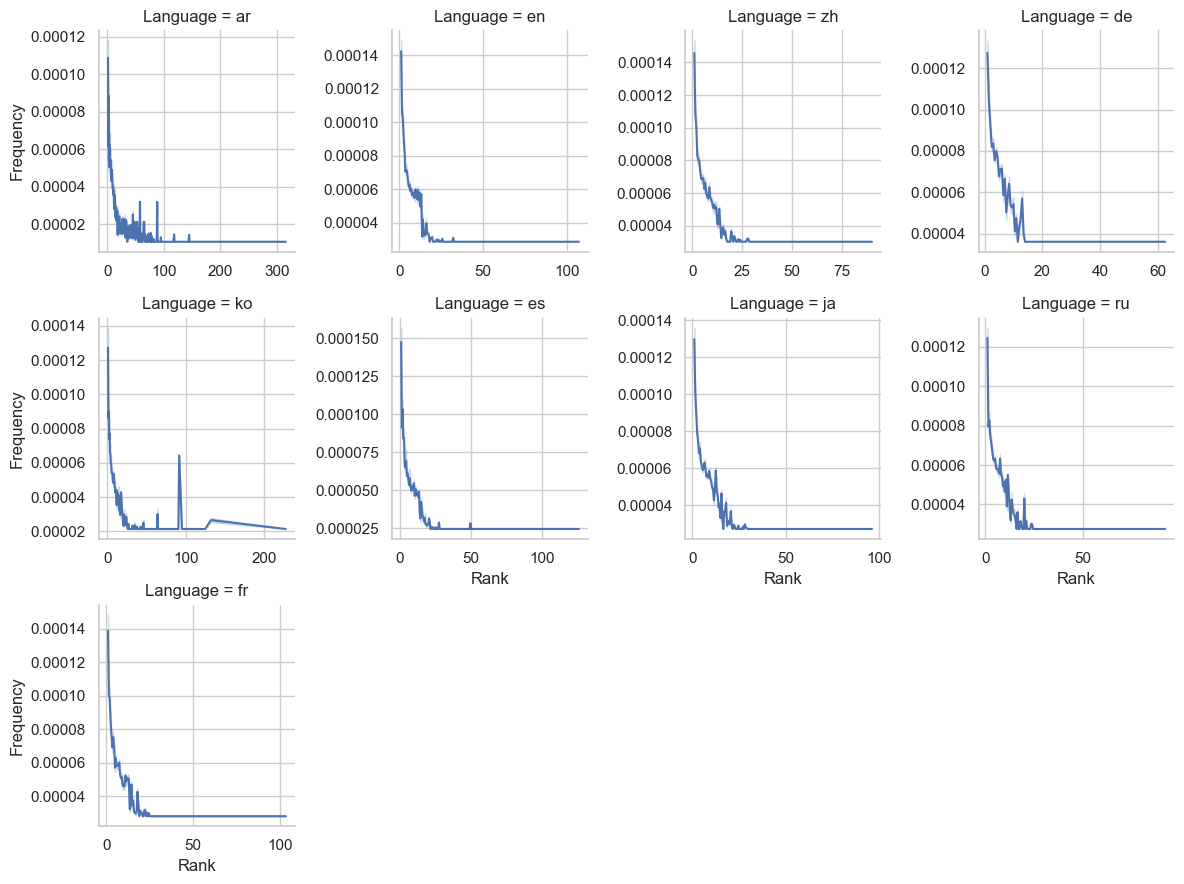

In [ ]:
def plot_zipf(data: pd.DataFrame) -> plt.Figure:
    """
    Crée un graphique de la loi de Zipf pour chaque langue.

    Parameters:
    data (pd.DataFrame): les données

    Returns:
    plt.Figure: l'objet Figure contenant le graphique
    """
    sns.set(style="whitegrid")
    g = sns.FacetGrid(data, col="Language", col_wrap=4, sharex=False, sharey=False)
    g.map(sns.lineplot, "Rank", "Frequency")

    return g.fig


zipf = plot_zipf(zipf_results)
zipf.savefig("../../results/zipf.png", facecolor="white", dpi=300)

1. **`loi_zipf_par_lang(data: pd.DataFrame) -> pd.DataFrame`**:
   Cette fonction calcule la loi de Zipf pour chaque langue dans un DataFrame donné.

   Voici ce qu'elle fait :
   - Prend en entrée un DataFrame `data` contenant des colonnes "Text" (texte à analyser) et "Label" (langue du texte ou "unknown").
   - Initialise un dictionnaire `results` qui va stocker les DataFrames des fréquences des tokens pour chaque langue.
   - Parcourt chaque texte et sa langue correspondante dans le DataFrame.
   - Tokenise le texte en utilisant la fonction `tokenize(text)` après avoir retiré les préfixes d'underscore des tokens avec `.lstrip("▁")`.
   - Compte la fréquence des tokens à l'aide de `pd.Series(tokens).value_counts()`, réinitialise l'index du résultat pour créer un DataFrame et renomme les colonnes en "Token" et "Frequency".
   - Attribue des rangs basés sur la fréquence en ordre décroissant.
   - Normalise les fréquences en divisant chaque fréquence par la somme totale des fréquences dans sa langue respective.
   - Stocke les résultats dans le dictionnaire `results` sous la clé correspondant à chaque langue.
   - Concatène tous les DataFrames de résultats pour chaque langue en un seul DataFrame, ordonne les colonnes et retourne ce DataFrame final.

2. **`plot_zipf(data: pd.DataFrame) -> plt.Figure`**:
   Cette fonction trace la loi de Zipf pour chaque langue dans un DataFrame donné.
   
   Voici ce qu'elle fait :
   - Prend en entrée un DataFrame `data` contenant les résultats de la loi de Zipf pour chaque langue, avec des colonnes "Token", "Frequency", "Rank", et "Language".
   - Utilise `sns.set(style="whitegrid")` pour définir le style des graphiques.
   - Crée une grille de facettes (`FacetGrid`) avec `sns.FacetGrid`, en spécifiant une colonne pour chaque langue. La grille ne partage ni les axes X ni Y entre les différentes facettes, ce qui permet d'ajuster chaque graphique à ses propres échelles de données.
   - Applique `sns.lineplot` pour tracer un graphique en ligne pour la fréquence contre le rang pour chaque langue.
   - Retourne l'objet `Figure` contenant le graphique.

En résumé, la première fonction prépare et analyse les données en calculant les fréquences de mots selon la loi de Zipf, et la deuxième fonction visualise ces données pour chaque langue. 